In [1]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [2]:
import numpy as np
import cv2
import tarfile
from pathlib import Path
from tqdm import tqdm
import shutil
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers as tfl
from tensorflow.keras.layers import *
from tensorflow_addons.image import transform as H_transform
import matplotlib.pyplot as plt
import os, datetime

from models.utils import shared_encoder, detector_head, descriptor_head, detector_loss, descriptor_loss, model_metrics, box_nms
from utils.tools import dict_update

In [3]:
seed = 1

In [4]:
!pwd

/root/Internship-Valeo/Project


In [5]:
DATA_PATH = '/root/Internship-Valeo/Project/data'

In [6]:
from datasets import synthetic_dataset
from datasets.utils import pipeline
from datasets.utils.pipeline import parse_primitives
from datasets.utils import photometric_augmentation as photaug
from models.homographies import (sample_homography, compute_valid_mask,
                                            warp_points, filter_points, flat2mat, mat2flat)
from models.utils import box_nms

In [7]:
# read keypoints
def _read_points(filename):
    return np.load(filename).astype(np.float32)

In [8]:
default_config = {
        'dataset': 'hpatches',  # or 'coco'
        'alteration': 'all',  # 'all', 'i' for illumination or 'v' for viewpoint
        'cache_in_memory': False,
        'truncate': None,
        'preprocessing': {
            'resize': False
        }
    }

In [9]:
import yaml
with open('/root/Internship-Valeo/Project/configs/superpoint_hpatches.yaml', 'r') as stream:
    config = yaml.safe_load(stream)

In [10]:
config1 = config
config = dict_update(default_config, config['data'])

In [11]:
default_model_config = {
            'data_format': 'channels_first',
            'grid_size': 8,
            'detection_threshold': 0.4,
            'descriptor_size': 256,
            'batch_size': 32,
            'learning_rate': 0.001,
            'lambda_d': 250,
            'descriptor_size': 256,
            'positive_margin': 1,
            'negative_margin': 0.2,
            'lambda_loss': 0.0001,
            'nms': 0,
            'top_k': 0,
    }

In [12]:
model_config = dict_update(default_model_config, config1['model'])

In [13]:
model_config['data_format']

'channels_last'

In [14]:
class HomographyLayer(Layer):
    def call(self, inputs):
        return inputs

def HomographyModel(shape = (8,)):
    x = Input(shape)
    output = HomographyLayer(name="homography_layer", trainable=False)(x)
    return keras.models.Model(inputs = x, outputs = output)

class DescriptorLossLayer(Layer):
    def __init__(self, name='descriptor_loss_layer', trainable=False):
        super(DescriptorLossLayer, self).__init__(name=name)
        self.loss_fn = descriptor_loss
#         self.accuracy_fn = keras.metrics.BinaryAccuracy(name="accuracy")

    def call(self, inputs, targets=None, sample_weight=None):
        loss = model_config['lambda_loss'] * self.loss_fn(descriptors = inputs[0], 
                                                          warped_descriptors = inputs[1],
                            homographies = inputs[2], valid_mask = inputs[3], **model_config)
        self.add_loss(loss)
#         return tf.reshape(loss, (1,))
        return loss
    def compute_output_shape(self, input_shape):
        return [1]
    
class DetectorLossLayer(Layer):
    def __init__(self, name='detector_loss_layer', trainable=False):
        super(DetectorLossLayer, self).__init__(name=name)
        self.loss_fn = detector_loss
        self.metrics_fn = model_metrics
#         self.accuracy_fn = keras.metrics.BinaryAccuracy(name="accuracy")

    def call(self, inputs, targets=None, sample_weight=None):
        loss = self.loss_fn(keypoint_map = inputs[0], logits = inputs[1]['logits'], 
                            valid_mask = inputs[2], model_config = model_config)
        
        if model_config['nms']:
            prob = tf.map_fn(lambda p: box_nms(p, model_config['nms'],
                                               min_prob=model_config['detection_threshold'],
                                               keep_top_k=model_config['top_k']), inputs[1]['prob'])
        pred = tf.cast(tf.greater_equal(prob, model_config['detection_threshold']), tf.float32)
        
        metrics = self.metrics_fn(inputs[0], pred)
        self.add_loss(loss)
        self.add_metric(metrics['precision'], name = 'detector_precision')
        self.add_metric(metrics['recall'], name = 'detector_recall')
        return loss
    def compute_output_shape(self, input_shape):
        return [1]

class WarpedDetectorLossLayer(Layer):
    def __init__(self, name='warped_detector_loss_layer', trainable=False):
        super(WarpedDetectorLossLayer, self).__init__()
        self.loss_fn = detector_loss
        self.metrics_fn = model_metrics
#         self.accuracy_fn = keras.metrics.BinaryAccuracy(name="accuracy")

    def call(self, inputs, targets=None, sample_weight=None):
        loss = self.loss_fn(keypoint_map = inputs[0], logits = inputs[1]['logits'], 
                            valid_mask = inputs[2], model_config = model_config)
        if model_config['nms']:
            prob = tf.map_fn(lambda p: box_nms(p, model_config['nms'],
                                               min_prob=model_config['detection_threshold'],
                                               keep_top_k=model_config['top_k']), inputs[1]['prob'])
        pred = tf.cast(tf.greater_equal(prob, model_config['detection_threshold']), tf.float32)
        
        metrics = self.metrics_fn(inputs[0], pred, valid_mask = inputs[2])
        self.add_loss(loss)
        self.add_metric(metrics['precision'], name = 'warped_detector_precision')
        self.add_metric(metrics['recall'], name = 'warped_detector_recall')
        return loss
    def compute_output_shape(self, input_shape):
        return [1]
    
def net():
    inputs = {'image':Input(shape = (240, 320, 1), name = 'image'),
              'name': Input(shape = (None,1), name = 'name'),
              'keypoints':Input(shape = (240,320), name = 'keypoints'),              
              'valid_mask':Input(shape = (240,320), name = 'valid_mask'),
              'warped':{
                  'image':Input(shape = (240, 320, 1), name = 'warped_image'),
                  'name': Input(shape = (None,1), name = 'warped_name'),
                  'keypoints':Input(shape = (240, 320), name = 'warped_keypoints'),
                  'valid_mask':Input(shape = (240, 320), name = 'warped_valid_mask'),
                  'homography':Input(shape = (8,), name = 'homography'),
               }}

#     inputs = OrderedDict((('image',Input(shape = (240, 320, 1), name = 'image')),
#               ('name', Input(shape = (), name = 'name')),
#               ('keypoints',Input(shape = (240,320), name = 'keypoints')),              
#               ('valid_mask',Input(shape = (240,320), name = 'valid_mask')),
#               ('warped',OrderedDict((
#                   ('image',Input(shape = (240, 320, 1), name = 'warped_image')),
#                   ('name', Input(shape = (), name = 'warped_name')),
#                   ('keypoints',Input(shape = (240, 320), name = 'warped_keypoints')),
#                   ('valid_mask',Input(shape = (240, 320), name = 'warped_valid_mask')),
#                   ('homography',Input(shape = (8,), name = 'homography')),))
#               )))

#     images_input = Input(shape = (240, 320,1), name = 'image')
#     points_maps_input = Input(shape = (240, 320), name = 'keypoints')
#     homography_list_input = Input(shape = (8,), name = 'homography') 
#     warped_images_input = Input(shape = (240, 320, 1), name = 'warped_image')

#     valid_masks_input = Input(shape = (240, 320), name = 'warped_valid_mask')
#     warped_points_maps_input = Input(shape = (240, 320), name = 'warped_keypoints')
    
    if model_config['data_format'] == 'channels_first':
#         images_input = tf.transpose(images_input, [0, 3, 1, 2])
        inputs['image'] = tf.transpose(inputs['image'], [0, 3, 1, 2])
#         warped_images_input = tf.transpose(warped_images_input, [0, 3, 1, 2])
        inputs['warped']['image'] = tf.transpose(inputs['warped']['image'], [0, 3, 1, 2])
    homography_model = HomographyModel()
#     homography = homography_model(homography_list_input)
    homography = homography_model(inputs['warped']['homography'])
    
    encoder = shared_encoder(shape = (240, 320, 1), model_config = model_config)
    encoder_output = encoder(inputs['image'])
    warped_encoder_output = encoder(inputs['warped']['image'])
    
    detector = detector_head(shape= (30, 40, 128), model_config = model_config)
    detector_output = detector(encoder_output)
    warped_detector_output = detector(warped_encoder_output)
    
    descriptor = descriptor_head(shape= (30, 40, 128), model_config=model_config)
    descriptor_output = descriptor(encoder_output)
    warped_descriptor_output = descriptor(warped_encoder_output)
    
    if model_config['data_format'] == 'channels_first':
        detector_output['logits'] = tf.transpose(detector_output['logits'], [0, 3, 1, 2])
        warped_detector_output['logits'] = tf.transpose(warped_detector_output['logits'], [0, 3, 1, 2])
        descriptor_output['descriptors_raw'] = tf.transpose(descriptor_output['descriptors_raw'], [0, 3, 1, 2])
        warped_descriptor_output['descriptors_raw'] = tf.transpose(warped_descriptor_output['descriptors_raw'], [0, 3, 1, 2])

#     detector_loss_layer = DetectorLossLayer()([points_maps_input, detector_output])
    detector_loss_layer = DetectorLossLayer()([inputs['keypoints'],
                                                 detector_output, inputs['valid_mask']])
#     warped_detector_loss_layer = WarpedDetectorLossLayer()([warped_points_maps_input, 
#                                                 warped_detector_output, 
#                                                       valid_masks_input])
    warped_detector_loss_layer = WarpedDetectorLossLayer()([inputs['warped']['keypoints'], 
                                                warped_detector_output, 
                                                      inputs['warped']['valid_mask']])
    
#     descriptor_loss_layer = DescriptorLossLayer()([descriptor_output['descriptors_raw'],
#                                                    warped_descriptor_output['descriptors_raw'], 
#                                           homography, valid_masks_input])
    descriptor_loss_layer = DescriptorLossLayer()([descriptor_output['descriptors_raw'],
                                                   warped_descriptor_output['descriptors_raw'], 
                                          inputs['warped']['homography'], inputs['warped']['valid_mask']])
    model = keras.models.Model(inputs = inputs,#images_input, homography_list_input, 
#                                          warped_images_input, 
#                                          valid_masks_input, 
#                                          points_maps_input, warped_points_maps_input],
                                        
                               outputs = [detector_loss_layer, warped_detector_loss_layer, 
                                          descriptor_loss_layer])
    return model

In [15]:
model = net()

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


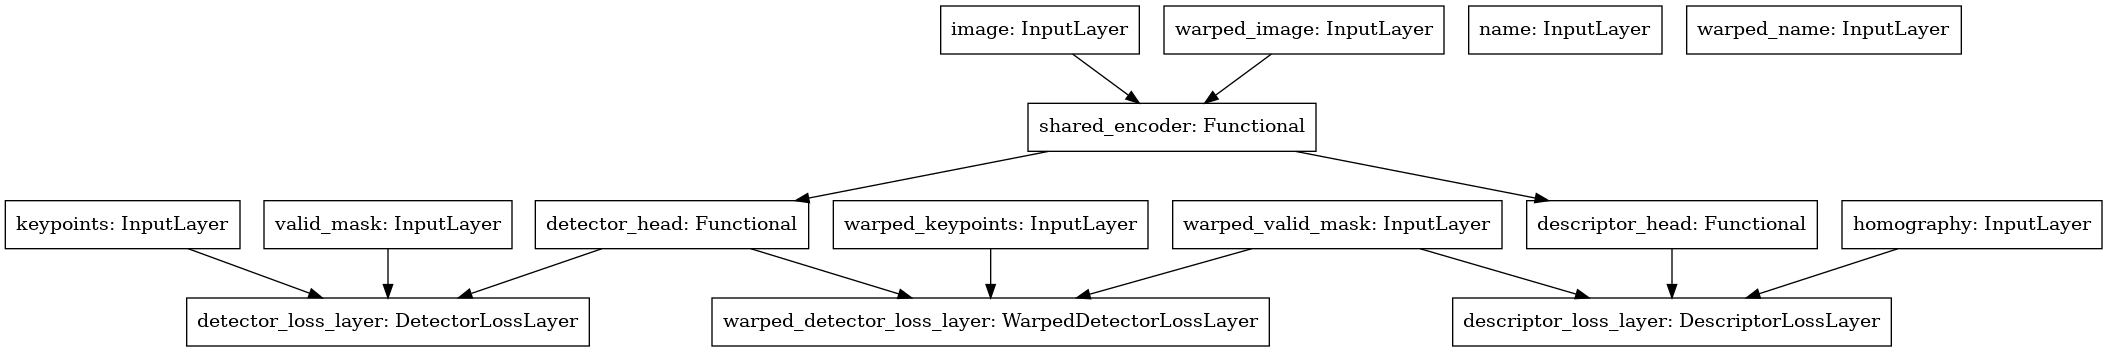

In [16]:
# model.summary()
keras.utils.plot_model(model, to_file="model.png", show_shapes = False, show_dtype=False, show_layer_names=True,
    rankdir="TB", expand_nested=False, dpi=96)

In [17]:
model.load_weights('/root/Internship-Valeo/Project/results/checkpoint-superpoint-coco-07042022')

In [18]:
# Make changes here for illumination vs viewpoint

config['alteration'] = 'v'

In [19]:
# Make changes here for illumination vs viewpoint

# output_dir = '/root/Internship-Valeo/Project/exports/superpoint_hpatches-i'
output_dir = '/root/Internship-Valeo/Project/exports/superpoint_hpatches-v'

In [20]:
from datasets import patches_dataset
data = patches_dataset.PatchesDataset()
files = data._init_dataset(**config)
# train_gen = data._get_data(files, 'training', **config)
# train_gen = train_gen.batch(5)
val_gen = data._get_data(files, 'validation', **config)
# val_gen = val_gen.batch(5)

In [21]:
from keras.models import Model

model = model # include here your original model

In [22]:
model.input

{'image': <KerasTensor: shape=(None, 240, 320, 1) dtype=float32 (created by layer 'image')>,
 'name': <KerasTensor: shape=(None, None, 1) dtype=float32 (created by layer 'name')>,
 'keypoints': <KerasTensor: shape=(None, 240, 320) dtype=float32 (created by layer 'keypoints')>,
 'valid_mask': <KerasTensor: shape=(None, 240, 320) dtype=float32 (created by layer 'valid_mask')>,
 'warped': {'image': <KerasTensor: shape=(None, 240, 320, 1) dtype=float32 (created by layer 'warped_image')>,
  'name': <KerasTensor: shape=(None, None, 1) dtype=float32 (created by layer 'warped_name')>,
  'keypoints': <KerasTensor: shape=(None, 240, 320) dtype=float32 (created by layer 'warped_keypoints')>,
  'valid_mask': <KerasTensor: shape=(None, 240, 320) dtype=float32 (created by layer 'warped_valid_mask')>,
  'homography': <KerasTensor: shape=(None, 8) dtype=float32 (created by layer 'homography')>}}

In [23]:
descriptor_model = Model(inputs=[model.input['image'], model.input['warped']['image']],                                 
                         outputs=model.get_layer('descriptor_loss_layer').input[0:2])

In [24]:
model.get_layer('descriptor_loss_layer').input

[<KerasTensor: shape=(None, 30, 40, 256) dtype=float32 (created by layer 'descriptor_head')>,
 <KerasTensor: shape=(None, 30, 40, 256) dtype=float32 (created by layer 'descriptor_head')>,
 <KerasTensor: shape=(None, 8) dtype=float32 (created by layer 'homography')>,
 <KerasTensor: shape=(None, 240, 320) dtype=float32 (created by layer 'warped_valid_mask')>]

In [25]:
detector_model = Model(inputs=[model.input['image'], model.input['warped']['image']],                                 
                         outputs=[model.get_layer('detector_loss_layer').input[1]['prob'], 
                                  model.get_layer('warped_detector_loss_layer').input[1]['prob']])

In [26]:
model.get_layer('detector_loss_layer').input

[<KerasTensor: shape=(None, 240, 320) dtype=float32 (created by layer 'keypoints')>,
 {'logits': <KerasTensor: shape=(None, 30, 40, 65) dtype=float32 (created by layer 'detector_head')>,
  'prob': <KerasTensor: shape=(None, 240, 320) dtype=float32 (created by layer 'detector_head')>},
 <KerasTensor: shape=(None, 240, 320) dtype=float32 (created by layer 'valid_mask')>]

In [27]:
model.get_layer('warped_detector_loss_layer').input

[<KerasTensor: shape=(None, 240, 320) dtype=float32 (created by layer 'warped_keypoints')>,
 {'logits': <KerasTensor: shape=(None, 30, 40, 65) dtype=float32 (created by layer 'detector_head')>,
  'prob': <KerasTensor: shape=(None, 240, 320) dtype=float32 (created by layer 'detector_head')>},
 <KerasTensor: shape=(None, 240, 320) dtype=float32 (created by layer 'warped_valid_mask')>]

In [ ]:
from tqdm import tqdm
val_gen = val_gen.batch(1)
x = iter(val_gen)

pbar = tqdm(total=config1['eval_iter'] if config1['eval_iter'] > 0 else None)
i = 0
while True:
    try:
        data = x.get_next()
    except data.end_set:
        break
    data1 = {'image': data['image'][0]}
    data2 = {'image': data['warped_image'][0]}
    
    detector_output = detector_model.predict(data)
    prob1 = tf.map_fn(lambda p: box_nms(
                p, model_config['nms'], keep_top_k=model_config['top_k']), detector_output[0])
    
    prob2 = tf.map_fn(lambda p: box_nms(
                p, model_config['nms'], keep_top_k=model_config['top_k']), detector_output[1])
    
    descriptor_output = descriptor_model.predict(data)    
    
    y = descriptor_output[0]
    cfirst = model_config['data_format'] == 'channels_first'
    cindex = 1 if cfirst else -1  # index of the channel

    desc1 = tf.transpose(y, [0, 2, 3, 1]) if cfirst else y
    desc1 = tf.image.resize(
            desc1, model_config['grid_size'] * tf.shape(desc1)[1:3], method='bilinear')
    desc1 = tf.transpose(desc1, [0, 3, 1, 2]) if cfirst else desc1
    desc1 = tf.nn.l2_normalize(desc1, cindex)
    
    pred1 = desc1
    
    y = descriptor_output[1]
    desc2 = tf.transpose(y, [0, 2, 3, 1]) if cfirst else y
    desc2 = tf.image.resize(
            desc2, model_config['grid_size'] * tf.shape(desc2)[1:3], method='bilinear')
    desc2 = tf.transpose(desc2, [0, 3, 1, 2]) if cfirst else desc2
    desc2 = tf.nn.l2_normalize(desc2, cindex)
    
    pred2 = desc2
    
    pred = {'image': data['image'][0],
            'warped_image': data['warped_image'][0],
            'prob': prob1,
                    'warped_prob': prob2,
                    'desc': pred1,
                    'warped_desc': pred2,
                    'homography': data['homography']}

#     if not ('name' in data):
#         pred.update(data)
    filename = data['name'][0].decode('utf-8') if 'name' in data else str(i)
    filepath = Path(output_dir, '{}.npz'.format(filename))
    np.savez_compressed(filepath, **pred)
    i += 1
    pbar.update(1)
    if i == config1['eval_iter']:
        break

  0%|          | 0/600 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: Input dict contained keys ['homography'] which did not match any model input. They will be ignored by the model.
  return py_builtins.overload_of(f)(*args)
  7%|▋         | 42/600 [05:46<1:14:52,  8.05s/it]